In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
#import cupy as cp
import numpy as np
import re

In [2]:
c=4
chunks = glob.glob('\\\\wsl.localhost\\Debian\\home\\grant\\NNRNA\\encoded\\*\\*')
df = pd.read_csv(chunks[c], index_col=0).sample(10000)
names = list(df.index)
for n, m in enumerate(names):
    names[n] = str.split(m, ":")
metadf = pd.DataFrame(names)
cell_list = list(metadf[4].unique())

# Gene counts are as easy as groupby()

In [3]:
#We get a denoised gene-count by using a simple group-by.
#372 resulting rows detailing gene counts for 5 cells

df['cell']=metadf[4].to_numpy()
dfg = df.groupby('cell').value_counts()

In [4]:
worm_reads=glob.glob("C:\\Users\\gbwie\\Documents\\School\\BioInfo\\TermPaper\\Data\\fastq\\*.csv")

In [98]:
worm = pd.read_csv(worm_reads[0], index_col=0).sample(10000)

In [99]:
worm["cell"]="worm"

In [108]:
pd.DataFrame(df[df["cell"]=="worm"].value_counts())

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,cell,
1.521921,1.541173,1.541173,1.541173,0.649714,0.24012,0.24012,0.24012,0.685943,0.389544,0.389544,0.389544,-0.725356,0.007296,0.007296,0.007296,0.663879,0.801022,0.801022,0.801022,0.007122,-0.030847,-0.030847,-0.030847,0.044155,0.004188,0.004188,0.004188,-0.03983,-0.016082,-0.016082,-0.016082,0.015566,0.033398,0.033398,0.033398,0.030812,0.024516,0.024516,0.024516,-0.192767,-0.986857,-0.986857,-0.986857,0.064125,0.056226,0.056226,0.056226,-0.229375,-0.570573,-0.570573,-0.570573,-0.466782,-0.197516,-0.197516,-0.197516,-0.056639,-0.036552,-0.036552,-0.036552,0.119592,0.095934,0.095934,0.095934,worm,10000


# From Vector Representations to Fingerprints

In [47]:
by_cell = {}
for n in cell_list:
    by_cell.update({n:df[df['cell']==n].drop(columns='cell')})

In [19]:
import umap
fit = umap.UMAP(
    n_neighbors=100,
    min_dist=0.1,
    n_components=2,
    metric='euclidean'
)

fit.fit(df.drop(columns='cell').to_numpy())

UMAP(n_neighbors=100, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [73]:
hist_list = []
mapped_list = []
for n, m in enumerate(cell_list):
    cell_name = m
    mapped = fit.transform(by_cell[m])
    mapped_list.append(mapped)

eigen_arr = np.concatenate(mapped_list)
eigen_cell = np.histogram2d(eigen_arr[:,0], eigen_arr[:,1], bins=8)
x_edges = eigen_cell[1]
y_edges = eigen_cell[2]


worm_map = fit.transform(worm.drop(columns='cell').values)
worm_map = np.histogram2d(worm_map[:,0], worm_map[:,1], bins=[x_edges, y_edges])

In [74]:
for umapped in mapped_list:
    hist = np.histogram2d(umapped[:,0], umapped[:,1], bins=[x_edges, y_edges])
    hist_props = (hist[0]/hist[0].max())/hist[0].std()
    hist_list.append(hist_props)

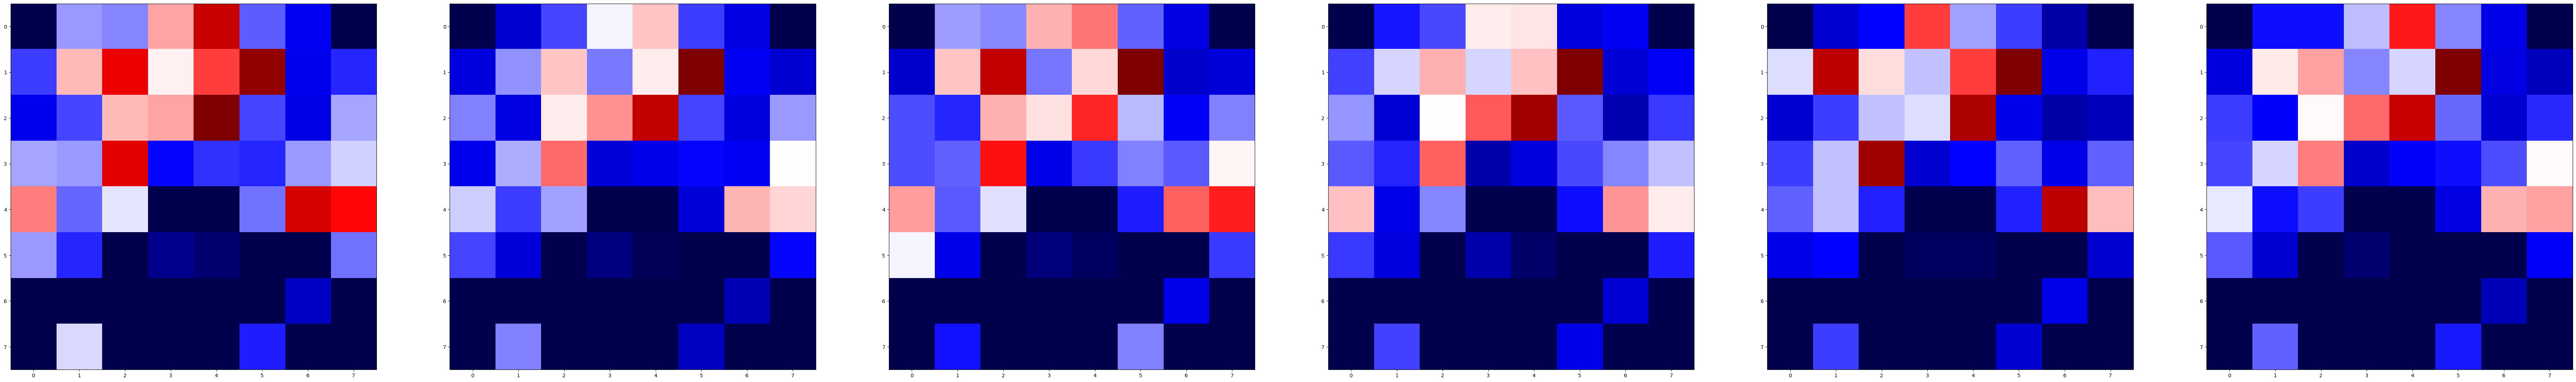

In [75]:
fig, ax = plt.subplots(1, len(hist_list)+1)
for h, i in enumerate(hist_list):
    ax[h-1].imshow(i, cmap='seismic')
    
ax[-1].imshow(worm_map, cmap='seismic')
fig.set_figwidth(90)
fig.set_figheight(15)

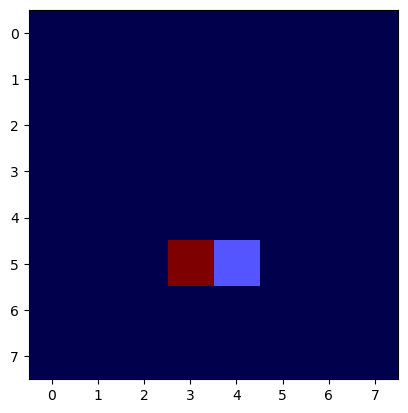

In [106]:
plt.imshow(worm_map[0], cmap='seismic')

# Or - we could use another autoencoder

Gene counts are one-dimensional; They don't account for similarity between different genes. Autoencoders can be used to capture both magnitude of expression, an similarity between the genes.

- read into a file
- select from each file n reads at random (10k?)
- Create embedding for those reads
- ???
- Profit

In [8]:
from torch import utils
from torch.utils import data
import utils

import gzip
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from Bio import SeqIO
import torch


def gpu_status():
    gpu_present = [torch.cuda.device(i) for i in range(torch.cuda.device_count())] != []
    print("GPU Detected?: " + str(gpu_present))
    if gpu_present:
        torch.set_default_device('cuda')
    device = (
        "cuda"
        if torch.cuda.is_available()
        else "mps"
        if torch.backends.mps.is_available()
        else "cpu"
    )
    print(f"Using {device} device")
    return device


def get_seqios(file):
    seqs = {}
    if file[-2::] == "gz":
        with gzip.open(file, 'rt') as fastq:
            for index, record in enumerate(SeqIO.parse(fastq, 'fastq')):
                seqs.update({record.id:str(record.seq)})
            return seqs

    else:
        with open(file, "r") as fastq:
            for index, record in enumerate(SeqIO.parse(fastq, 'fastq')):
                seqs.update({record.id:str(record.seq)})
            return seqs


def parse_reads(record, pad_size):
    enc = OneHotEncoder()
    enc.fit(np.array(["A", "T", "C", "G", "N"]).reshape(-1, 1))
    x_in = np.array(list(record))
    arr = enc.fit_transform(x_in.reshape(-1, 1)).toarray()
    delta = len(arr) - pad_size

    if delta > 0:
        # random crop
        shift = np.random.randint(0, delta)
        x_out = arr[shift:shift + pad_size]

    else:
        arr.resize((pad_size, 4), refcheck=False)
        x_out = arr

    return x_out


class mRNA_Encoder:

    def __init__(self, model, pad_size=1000, checkpoint=None):
        self.pad_size = pad_size
        self.model = model
        self.device = gpu_status()
        if checkpoint is not None:
            state_dict = torch.load(checkpoint)
            self.model.load_state_dict(state_dict=state_dict)

    class Dataset(data.Dataset):
        def __init__(self, training_path, pad_size):
            self.data = glob.glob(training_path)
            self.PAD_SIZE = pad_size

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            if torch.is_tensor(idx):
                idx = idx.tolist()

            path = self.data[idx]
            out = parse_reads(path, self.PAD_SIZE)
            out = out.reshape(self.PAD_SIZE, 4)
            out = torch.tensor(out).to(torch.float)
            return out

    def train_encoder(self, training_path, epochs=1, pad_size=1000, batch_size=1, lr=0.1, decay=1e-9):
        dataset = self.Dataset(training_path, pad_size)
        epochs = epochs
        batch_size = batch_size
        lr = lr
        decay = decay
        loss_function = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=decay)
        dataloader = torch.utils.data.DataLoader(dataset,
                                                 batch_size=batch_size,
                                                 shuffle=True,
                                                 num_workers=0,
                                                 generator=torch.Generator(device='cuda'))

        losses = []
        for epoch in range(epochs):
            print("epoch" + str(epoch))
            batch = next(iter(dataloader))
            for batch_index, doc in enumerate(batch):
                recon = self.model(doc)
                # Loss function
                loss = loss_function(recon, doc)
                if batch_index % 10 == 0:
                    print("Batch: " + str(batch_index))
                    print("loss" + str(loss))

                # Gradients are set to zero,
                # Gradient is computed and stored.
                # .step() performs parameter update.
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss)

        return self.model, losses

    def seq_to_embedding(self, seq):
        seq = parse_reads(seq, pad_size=self.pad_size)
        seq = torch.tensor(seq).to(torch.float)
        embedding = self.model.encoder(seq).cpu().detach().numpy().flatten()
        return embedding

    def embed_file(self, file):
        seqs = get_seqios(file)
        df = pd.DataFrame.from_dict(seqs, orient='index')
        with torch.no_grad():
            sample = df.apply(self.seq_to_embedding, axis=1, result_type='expand')
        return sample

    def embed_fastqs(self, in_filepath="", out_filepath=""):
        fastqs = glob.glob(in_filepath + "*.fastq.gz")
        for n, file in enumerate(fastqs):
            subbed = re.sub("fastq", "encoded", file)
            subbed = re.sub(".fastq.gz", ".csv", subbed)
            encoded = self.embed_file(file)
            encoded.to_csv(out_filepath + subbed)
            print("Finished: " + str(n) + " Of " + str(len(fastqs)))

In [10]:
import Base_Model
import torch
model = Base_Model.AE(pad_size=1000)
# todo: why does this happen twice? Once here:
state = torch.load("C:\\Users\\gbwie\\Documents\\School\\BioInfo\\TermPaper\\RNA_Autoencoder.state_dict")
model.load_state_dict(state_dict=state)
model.cuda()
# And then again here.
encoder = mRNA_Encoder(model=model, pad_size=1000, checkpoint="C:\\Users\\gbwie\\Documents\\School\\BioInfo\\TermPaper\\RNA_Autoencoder.state_dict")

GPU Detected?: True
Using cuda device


In [151]:
#This only has to be run once
youre_sure=False
if youre_sure:
    import re
    worm_path = "C:\\Users\\gbwie\\Documents\\School\\BioInfo\\TermPaper\\Data\\fastq\\*"
    worm_samples= glob.glob(worm_path)
    for n in worm_samples:
        print(n)
        embedded = encoder.embed_file(n)
        embedded.to_csv(re.sub(".fastq.gz", ".csv", n))

In [ ]:
tub_cells = glob.glob("\\\\wsl.localhost\\Debian\\home\\grant\\fasterq\\*.fastq")
encoder.embed_file(tub_cells[0])

In [11]:
#This all works, but only for pre-tokenized datasets stored in csv format. Sorry.

def get_file(filepath):
    df = pd.read_csv(filepath, index_col=0)
    names = list(df.index)
    for n, m in enumerate(names):
        names[n] = str.split(m, ":")
    metadf = pd.DataFrame(names)
    df["cell"]=(metadf[4].to_numpy())
    return df

def get_cell(df, cell, size, resample=True):
    size = int(size)
    sample = df[df["cell"]==cell].drop(columns='cell')
    replace = False==(sample.shape[0]>size)
    if resample:
        sample = sample.sample(size, replace=replace)
    else:
        if not replace:
            sample = sample.sample(size)
        if replace:
            pad = np.zeros((int(size), 64))
            pad[:sample.shape[0],:sample.shape[1]]=sample
            sample = pad
    return np.array(sample).flatten()

def get_dataset(filepath, size=1e4, limit=None):
    # Filepath uses glob. example useage: ./*, ../data/*.fastq or home/data/*/*.fastq.gz
    size=int(size)
    samples = []
    names = []
    chunks = glob.glob(filepath)
    if limit is not None:
        chunks = chunks[0:(min(limit, len(chunks)))]
    for file in chunks:
        df = get_file(file)
        cell_list = df["cell"].unique()
        for cell in cell_list:
            samples.append(get_cell(df, cell, size=size, resample=True))
            name = str.split(file, "\\")[-1]+":"+cell
            names.append(name)

    return dict(zip(names,samples))

In [ ]:
human_samples = get_dataset('\\\\wsl.localhost\\Debian\\home\\grant\\NNRNA\\encoded\\*\\*', size=1e4, limit=1000)

In [245]:
stages=[]
worm_reads=glob.glob("C:\\Users\\gbwie\\Documents\\School\\BioInfo\\TermPaper\\Data\\fastq\\*.csv")
worm_samples=[]
for worm in worm_reads:
    stages.append((str.split(worm, "\\")[-1]))
    #get a set we'll make 10 samples from
    new = pd.read_csv(worm).sample(int(1e5), replace=True)
    new.drop(columns="Unnamed: 0", inplace=True)
    new = np.split(new.to_numpy(), 10)
    for n in new:
        worm_samples.append(n.flatten())

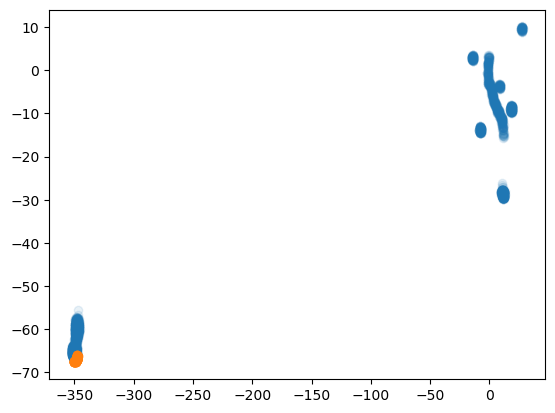

In [256]:
fit = umap.UMAP(
    n_neighbors=50,
    min_dist=1,
    n_components=2,
    metric='euclidean'
)

cell_map = fit.fit_transform(np.array(list(human_samples.values())))
worm_map = fit.transform(worm_samples)
plt.scatter(cell_map[:,0], cell_map[:,1], alpha=0.1)
plt.scatter(worm_map[:,0], worm_map[:,1])

When we zoom in on the worm cells, we see they cluster near the outside of a specific subgroup of human kidney cells.

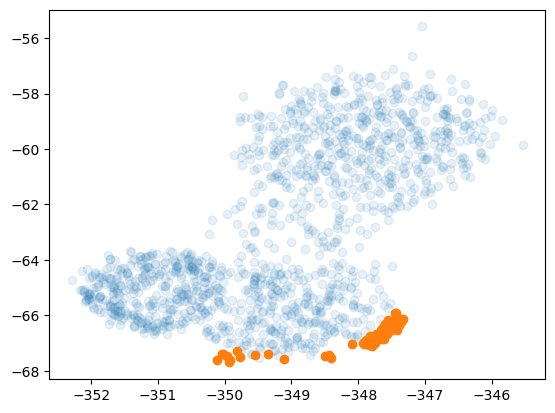

In [259]:
cuzoom = cell_map[(cell_map[:,0]<-200)]
wuzoom = worm_map[worm_map[:,0]<-200]
plt.scatter(cuzoom[:,0], cuzoom[:,1], alpha=0.1)
plt.scatter(wuzoom[:,0], wuzoom[:,1])

In [268]:
pd.DataFrame.from_dict(dict(zip(human_samples.keys(), cell_map)), orient='index').sort_values(by=0)

,0,1
read-RA_si-ATCGCTCC_lane-003-chunk-003.csv:11402,-352.294434,-64.733742
read-RA_si-AGACTTTC_lane-003-chunk-003.csv:11403,-352.169739,-65.077148
read-RA_si-GTTTGCCT_lane-003-chunk-003.csv:11402,-352.142059,-64.401352
read-RA_si-CAACCATC_lane-003-chunk-003.csv:11403,-352.133057,-65.077286
read-RA_si-GATGCAGT_lane-002-chunk-000.csv:11102,-352.115936,-65.168678
...,...,...
read-I2_si-CAACCATC_lane-001-chunk-001.csv:11105,27.848001,9.317010
read-I2_si-GATAGGTA_lane-003-chunk-003.csv:11401,27.888054,9.447542
read-I2_si-GATAGGTA_lane-003-chunk-003.csv:11404,27.904284,9.584584
read-I2_si-CAACCATC_lane-003-chunk-003.csv:11404,27.949652,9.762903
